# Playing with Deep RL Algorithms in OpenAI Gym!
- We will be trying Q-Networks, DQN, Double DQN, Experience Replay, Prioritized Experience Replay, Actor-Critic Model and Proximal Policy Optimization

## Mounting Google Drive to save models

In [ ]:
from google.colab import drive
from google.colab import files
from google.colab import auth
import os
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from oauth2client.client import GoogleCredentials
import pickle


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Change directory to store the models and pickled objects
os.chdir('/content/drive/My Drive/Colab Notebooks/RL Training')

## Initializing the monitor wrapper for Colab
Code provided by: https://colab.research.google.com/drive/1flu31ulJlgiRL1dnN2ir8wGh9p7Zij2t?usp=sharing

In [ ]:
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (47.3.1)


In [ ]:
import gym
from gym import logger as gymlogger
from gym.wrappers import Monitor
gymlogger.set_level(40) #error only
import tensorflow as tf
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import math
import glob
import io
import base64
from IPython.display import HTML

from IPython import display as ipythondisplay
import pandas as pd
import seaborn as sb
from IPython.display import clear_output
import time
from datetime import date, datetime, timedelta

sb.set()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from pyvirtualdisplay import Display
display = Display(visible=0, size=(1400, 900))
display.start()

In [ ]:
"""
Utility functions to enable video recording of gym environment and displaying it
To enable video, just do "env = wrap_env(env)""
"""

def show_video():
  mp4list = glob.glob('video/*.mp4')
  if len(mp4list) > 0:
    mp4 = mp4list[0]
    video = io.open(mp4, 'r+b').read()
    encoded = base64.b64encode(video)
    ipythondisplay.display(HTML(data='''<video alt="test" autoplay 
                loop controls style="height: 400px;">
                <source src="data:video/mp4;base64,{0}" type="video/mp4" />
             </video>'''.format(encoded.decode('ascii'))))
  else: 
    print("Could not find video")
    

def wrap_env(env):
  env = Monitor(env, './video', force=True)
  return env

### Pac-Man!

In [ ]:
env = wrap_env(gym.make("MsPacman-v0"))

In [ ]:
#check out the pacman action space!
print(env.action_space)

Discrete(9)


In [ ]:
observation = env.reset()

while True:
  
    env.render()
    
    #your agent goes here
    action = env.action_space.sample() 
         
    observation, reward, done, info = env.step(action) 
   
        
    if done: 
      break;
            
env.close()
show_video()

## Great, so the video wrapper now works in Google Colab!

In [ ]:
# Easy changing of OpenAI Gym environments

# Using non-discrete action-space or observation space would require discretization of it into small buckets to plug and play into the below models. Can also add neurons within layers as well as additional layers for higher complexity
environments = [
                'FrozenLake-v0',
                'CartPole-v1',
                'Pendulum-v0'
]

In [ ]:
## Uncomment to run the environment with video, using random sampling. Works for discrete action spaces

# env = wrap_env(gym.make(environments[0]))

# observation = env.reset()
# done = False

# while not done:
#   action = env.action_space.sample()
#   observation, reward, done, info = env.step(action)
#   clear_output(wait = True)
#   time.sleep(0.5)
#   env.render()

# env.close()
# show_video()

In [ ]:
class Agent():
  def __init__(self, env):
    ## Main
    self.action_discrete = type(env.action_space) == gym.spaces.discrete.Discrete
    self.observation_discrete = type(env.observation_space) == gym.spaces.discrete.Discrete

    if self.action_discrete:
      self.action_size = env.action_space.n
      print(f"Action Size: {self.action_size}\tDiscrete: {self.action_discrete}")
    else:
      self.action_high = env.action_space.high
      self.action_low = env.action_space.low
      self.action_shape = env.action_space.shape
      print(f"Action High: {self.action_high}\t Action Low: {self.action_low}")
      print(f"Shape: {self.action_shape}\t Discrete: {self.action_discrete}")

    if self.observation_discrete:
      self.observation_size = env.observation_space.n
      print(f"Observation Size: {self.observation_size}\tDiscrete: {self.observation_discrete}")
    else:
      self.observation_high = env.observation_space.high
      self.observation_low = env.observation_space.low
      self.observation_shape = env.observation_space.shape
      print(f"Observation High: {self.observation_high}\t Observation Low:{self.observation_low}")
      print(f"Shape: {self.observation_shape}\t Discrete: {self.observation_discrete}")

In [ ]:
env = wrap_env(gym.make(environments[0]))
agent = Agent(env)

Action Size: 4	Discrete: True
Observation Size: 16	Discrete: True


In [ ]:
# An agent that picks a decision by random processes
class RAgent(Agent):
  def get_action(self, state):
    if self.action_discrete:
      action = random.randint(0, self.action_size - 1)
      return action
    else:
      return np.random.uniform(self.action_low, self.action_high, self.action_shape)

#### Training and running

In [ ]:
env = wrap_env(gym.make(environments[0]))
ragent = RAgent(env)

Action Size: 4	Discrete: True
Observation Size: 16	Discrete: True


In [ ]:
env = wrap_env(gym.make(environments[0]))

observations = env.reset()
done = False
while not done:
  action = ragent.get_action(observations)
  observations, reward, done, info = env.step(action)
  env.render()
  time.sleep(0.5)
  clear_output(wait = True)

  (Left)
SFFF
FHFH
FFFH
HFFG


### Utility Functions

#### Plotting Function for comparison

In [ ]:
def plot_train(total_rewards):
  if not total_rewards:
    print("No rewards!")
    return
    
  if type(total_rewards[0]) != list:
    x = [100*(var) for var in range(len(total_rewards) + 1)]
    y = [0] + total_rewards
    t = list(zip(x,y))
    temp = pd.DataFrame(t, columns = ['Episodes', 'Rewards Per 100 Episodes'])
    plot = sb.lineplot(x = temp['Episodes'], y = temp['Rewards Per 100 Episodes'])
    return plot

  for i, rewards in enumerate(total_rewards):
    x = [100*(var) for var in range(len(total_rewards[0]) + 1)]
    y = [0] + rewards
    plt.plot(x, y, label = f"Iteration {i+1}")
    plt.xlabel('Episodes')
    plt.ylabel('Rewards Per 100 Episodes')
  plt.legend()
  plt.show()

#### Saving and loading functions


In [ ]:
# Change this to change to offline
MODEL_SAVE_PATH = "/content/drive/My Drive/Colab Notebooks/RL Training/Agents"
MODEL_LOAD_PATH = "/content/drive/My Drive/Colab Notebooks/RL Training/Agents"

def save_model(agent, name, is_double = False):
  # Save the tf model first
  PATH = os.path.join(MODEL_SAVE_PATH, name)
  if is_double:
    save_double_model(agent, name)
  else:
    try:
      
      print("Saving model...")
      agent.model.save(PATH)
      print("Saved!")
    except:
      print("Saving of model failed! Skipping!")
  try:
    # Save the results
    temp = os.path.join(PATH, 'results.p')
    print("Saving results to:", temp)
    os.mkdir(PATH)
  except FileExistsError:
    print("Directory found!")
  try:
    with open(temp, 'wb') as f:
      pickle.dump(agent.total_rewards, f)
    print("Saved!")
  except:
    print("Saving of results failed! Skipping!")

def load_model(agent, name, is_double = False):
  if is_double:
    load_double_model(agent, name)
  else:
    try:
      PATH = os.path.join(MODEL_LOAD_PATH, name)
      agent.model = tf.keras.models.load_model(PATH)
      print("Loaded Model:")
      agent.model.summary()
      print("Weights of the output layer:")
      print(agent.model.get_layer(index = -1).get_weights())
      print()
    except:
      print("Model not found!")
      return False

  try:
    temp = os.path.join(PATH, 'results.p')
    with open(temp, 'rb') as f:
      agent.total_rewards = pickle.load(f)
    print(f"Loaded Rewards: {agent.total_rewards}")
    plot_train(agent.total_rewards)
    return True
  except:
    print("Failed to load past results!")
    return False

def store_results (agent, results):
  if agent.total_rewards:
    agent.total_rewards.append(results)
  else:
    agent.total_rewards = [results]

def end_training(agent, total_rewards, name, is_double = False):
  save_model(agent, name, is_double)
  store_results(agent, total_rewards)
  plot_train(agent.total_rewards)

def save_double_model(agent, name):
  PATH = os.path.join(MODEL_SAVE_PATH, name)
  try:
    os.mkdir(PATH)
  except:
    print("Path exists!")
  O_PATH = os.path.join(PATH,'online')
  T_PATH = os.path.join(PATH,'target')
  try:
    print("Saving networks")
    agent.online_network.save(O_PATH)
    agent.target_network.save(T_PATH)
    print("Saved!")
  except:
    print("Failed to save networks! Skipping!")

def load_double_model(agent, name):
  PATH = os.path.join(MODEL_LOAD_PATH, name)
  O_PATH = os.path.join(PATH, 'online')
  T_PATH = os.path.join(PATH, 'target')
  try:
    print("Loading online network")
    agent.online_network = tf.keras.models.load_model(O_PATH)
    agent.online_network.summary()
  except:
    print("Failed.")
  try:
    print("Loading target network.")
    agent.target_network = tf.keras.models.load_model(T_PATH)
    agent.target_network.summary()
  except:
    print("Failed. Skipping!")

## Q-Learning
A simple form of prediction and control is using the Q-Learning Algorithm. We will be using a q-lookup table initially to approximate the function, before moving onto a neural network to do so.

In [ ]:
# Agent that uses a Q-Lookup Table (Specific form of Q-Learning) to approximate it's value function
class QAgent(RAgent):
  def __init__(self, env, eps = 1.00, discount_rate = 0.99, learning_rate = 0.01):
    super().__init__(env)
    self.eps = eps
    self.discount_rate = discount_rate
    self.learning_rate = learning_rate
    self.plot = None
    self.total_rewards = None
    self.build_table()

  # This assumes a discrete action and observation state
  def build_table(self):
    self.q_table = 1e-4 * np.random.random([self.observation_size, self.action_size])

  def get_action(self, state):
    if np.random.uniform() < self.eps:
      return super().get_action(state)
    else:
      # Greedy Choice
      action_values = self.q_table[state]
      action = np.argmax(action_values)
      return action
  
  def train(self, experience):
    state, next_state, reward, action, done = experience
    q_next = self.q_table[next_state]
    q_next = np.zeros([self.action_size]) if done or state == next_state else q_next
    q_target = reward + self.discount_rate * np.max(q_next)

    # Loss Fn
    q_update = q_target - self.q_table[state,action]

    # Update the table with a learning rate
    self.q_table[state,action] += self.learning_rate * q_update 

    if done:
      self.eps *= 0.99
  
  def set_for_train(self, power = 0, operand = 10, epsilon = None):
    if epsilon != None:
      self.eps = epsilon
    change = operand ** (-1 * power)
    self.learning_rate *= change

#### Training and running

In [ ]:
env = wrap_env(gym.make(environments[0]))
qagent = QAgent(env)

Action Size: 4	Discrete: True
Observation Size: 16	Discrete: True


In [ ]:
train = False

In [ ]:
total_rewards = []
repetition = 10
episodes = 100
name = f'Q-Agent-{repetition}x{episodes}'
if train:
  for rep in range(repetition): 
    total_reward = 0
    for ep in range(episodes):
      observations = env.reset()
      done = False
      while not done:
        action = qagent.get_action(observations)
        next_observations, reward, done, info = env.step(action)
        qagent.train((observations, next_observations, reward, action, done))
        observations = next_observations
        print(f"Episode: {ep}\t Total Reward: {total_reward}\t")
        env.render()
        print(qagent.q_table)
        clear_output(wait = True)
      total_reward += reward
    total_rewards.append(total_reward)
  print("Done!")
  end_training(qagent, total_rewards, name)

### Neural Network as Value Function Approximators (Deep Q-Networks)

In [ ]:
class QNNAgent(QAgent):
  def build_table(self):
    self.model = tf.keras.models.Sequential(
        [
          tf.keras.layers.Dense(self.observation_size, input_shape=[self.observation_size]),
          tf.keras.layers.Dense(32, activation = 'relu'),
          tf.keras.layers.Dense(self.action_size)
        ]
    )

    loss_fn = tf.losses.MeanSquaredError()
    
    self.model.compile(
        optimizer = 'adam',
        loss = loss_fn,
        metrics = ['mse', 'mae']
    )
    self.model.summary()

  def train(self, observation, next_observation, action, reward, done):
    a = self.observation_size
    observation = self.one_hot(observation,a)
    next_observation = self.one_hot(next_observation,a)
    q_init = self.model.predict(observation)
    q_next = self.model.predict(next_observation) if not done else np.zeros((1,self.action_size))
    q_target = reward + np.max(q_next) * self.discount_rate
    q_init[0, action] = q_target
    self.model.fit(x = observation, y = q_init, verbose = 0)
    if done:
      self.eps *= 0.99
  
  def get_action(self, state):
    # Given current state, predict the q values of the next actions
    state = self.one_hot(state, self.observation_size)
    q_state = self.model.predict(state)
    # Greedy action = argmax(q_state)
    action_greedy = np.argmax(q_state)
    action_random = random.randint(0, self.action_size - 1)
    return action_random if np.random.uniform() < self.eps else action_greedy

  def one_hot(self, inpt, size, ax = 0, dtype = 'float32'):
    return tf.keras.utils.to_categorical(inpt, num_classes = size, dtype = dtype)

#### Training and running

In [ ]:
env = wrap_env(gym.make(environments[0]))
dqagent = QNNAgent(env)
repetitions = 0

Action Size: 4	Discrete: True
Observation Size: 16	Discrete: True
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 16)                272       
_________________________________________________________________
dense_1 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_2 (Dense)              (None, 4)                 132       
Total params: 948
Trainable params: 948
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train = False

Loaded Model:
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              multiple                  272       
_________________________________________________________________
dense_10 (Dense)             multiple                  544       
_________________________________________________________________
dense_11 (Dense)             multiple                  132       
Total params: 948
Trainable params: 948
Non-trainable params: 0
_________________________________________________________________
Weights of the output layer:
[array([[-2.27975156e-02,  1.70019552e-01, -1.18534461e-01,
        -1.31890386e-01],
       [ 1.36713594e-01,  5.38245998e-02,  1.80958539e-01,
         3.54531929e-02],
       [ 9.85876322e-02,  8.70476067e-02,  2.38718584e-01,
         4.04248983e-02],
       [ 3.21724027e-01,  3.31037968e-01,  2.97225237e-01,
         1.62389234e-01],
  

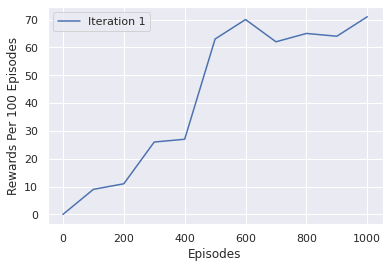

Train set to true


In [ ]:
total_rewards = []
repetition = 10
repetitions += repetition
episodes = 100
name = f"DQN-Agent-{repetitions}x{episodes}"
if train:
  # Results tend to even out at around 10 repetitions
  for rep in range(repetition):
    total_reward = 0
    for ep in range(episodes):
      observations = env.reset()
      done = False
      while not done:
        action = dqagent.get_action(observations)
        next_observations, reward, done, info = env.step(action)
        dqagent.train(observations, next_observations, action, reward, done)
        observations = next_observations
        print(f"Repetition: {rep}\t Total Rewards: {total_rewards}\nEpisode: {ep}\t Total Reward: {total_reward}\t")
        env.render()
        clear_output(wait = True)
      total_reward += reward
    total_rewards.append(total_reward)

  end_training(dqagent, total_rewards, name)
# Load the previous model and results
else:
  train = load_model(dqagent, name)
  train = True
  if train:
    print("Train set to true")

### Implementing a memory buffer

In [ ]:
from collections import deque
import random

class Memory():
  def __init__(self, min_buffer = 1, max_buffer = 100, sample_size = 1):
    self.memory = deque(maxlen = max_buffer)
    self.min_buffer = min_buffer
    self.sample_size = sample_size
  
  def store(self,entry):
    self.memory.append(entry)
  
  def sample(self, sample_size = 1):
    return random.choices(self.memory, k = sample_size) if len(self.memory) > self.min_buffer else None

In [ ]:
class DQNBufferAgent(QNNAgent):
  def __init__(self, env, eps = 1.00, discount_rate = 0.99, learning_rate = 0.01, min_buffer = 20, max_buffer = 100, sample_size = 10):
    super().__init__(env, eps, discount_rate, learning_rate)
    self.experience_buffer = Memory(min_buffer, max_buffer, sample_size)
    self.sample_size = sample_size

  def pack(self, episode_data):
    self.experience_buffer.store(episode_data)

  def train(self):
    batch = self.experience_buffer.sample(self.sample_size)
    if batch:
      observations, next_observations, actions, rewards, dones = self.unpack(batch)
      a = self.observation_size

      for i, observation in enumerate(observations):
        observations[i] = self.one_hot(observation, a)
      observations = np.array(observations)

      for i, next_observation in enumerate(next_observations):
        next_observations[i] = self.one_hot(next_observation,a)
      next_observations = np.array(next_observations)

      q_init = self.model.predict(observations)
      q_next = self.model.predict(next_observations)

      # Remove the predicted value of the next state at terminal states
      for i, d in enumerate(dones):
        if d:
          q_next[i,0] = np.zeros((1, self.action_size))
      
      # Convert rewards to a np array and reshape it
      l = len(rewards)
      rewards = np.array(rewards).reshape((l,1))

      # Update the q_init with the value func of next step + reward and discount
      q_targets = rewards + np.max(q_next, axis = 2) * self.discount_rate
      for i, q_target in enumerate(q_targets):
        q_init[i, 0][actions[i]] = q_target

      # Minimize loss fn
      self.model.fit(x = observations, y = q_init, verbose = 0)

  def unpack(self, episode_data):
    reordered = [list(exp) for exp in zip(*episode_data)]

    return reordered
  
  def step(self, env, observation):
    action = self.get_action(observation)
    next_observations, reward, done, info = env.step(action)
    state = [observation, next_observations, action, reward, done]
    if done:
      self.eps *= 0.99
    return state


#### Training and running


In [ ]:
env = wrap_env(gym.make(environments[0]))
dqbagent = DQNBufferAgent(env, max_buffer = 1000, sample_size = 20)
repetitions = 0

Action Size: 4	Discrete: True
Observation Size: 16	Discrete: True
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_4 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_5 (Dense)              (None, 4)                 132       
Total params: 948
Trainable params: 948
Non-trainable params: 0
_________________________________________________________________


In [ ]:
train = False

In [ ]:
total_rewards = []
repetition = 10
repetitions += repetition
episodes = 100
datetoday = str(date.today())
name = f"DQN-Buffer-Agent-{datetoday}-{repetitions}x{episodes}"
if train:
  for rep in range(repetition):
    total_reward = 0
    for ep in range(episodes):
      done = False
      observation = env.reset()
      while not done:
        state = dqbagent.step(env, observation)
        dqbagent.pack(state)
        print(f"Repetition: {rep}\tTotal Rewards:{total_rewards}\nEpisode: {ep}\tTotal Reward: {total_reward}\t Episilon: {dqbagent.eps}")
        print(f"Observation: {observation}\tAction: {state[2]}")
        observation = state[1]
        done = state[-1]
        total_reward += state[-2]
        env.render()
        clear_output(wait = True)
        if len(dqbagent.experience_buffer.memory) >= dqbagent.experience_buffer.min_buffer:
          dqbagent.train()
    total_rewards.append(total_reward)

  end_training(dqbagent, total_rewards, name)
else:
  load_model(dqbagent, name)
  print("Training set to True")
  train = True

Model not found!
Training set to True


### Double DQN with Experience Replay

In [ ]:
class DDQNBufferAgent(DQNBufferAgent):
  def __init__(self, env, eps = 1.00, discount_rate = 0.99, learning_rate = 0.01, min_buffer = 20, max_buffer = 1000, sample_size = 20, update_freq = 20):
    super().__init__(env, eps = 1.00, discount_rate = 0.99, learning_rate = 0.01, min_buffer = 20, max_buffer = 1000, sample_size = 20)
    self.online_network = self.build_table("OnlineNetwork")
    self.target_network = self.build_table("TargetNetwork")
    # Init target weights = online weights
    self.target_weights = self.target_network.get_weights()
    self.update_target()
    self.update_freq = update_freq
    self.current_iteration = 0

  def build_table(self, name = None):
    model = tf.keras.models.Sequential(
        [
          tf.keras.layers.Dense(self.observation_size, input_shape=([self.observation_size])),
          tf.keras.layers.Dense(32, activation = 'relu'),
          tf.keras.layers.Dense(self.action_size)
        ],
        name = name
    )

    loss_fn = tf.losses.MeanSquaredError()
    
    model.compile(
        optimizer = 'adam',
        loss = loss_fn,
        metrics = ['mse', 'mae']
    )
    model.summary()
    return model

  def train(self):
    # If buffer size too small, batch returned as None. Don't train.
    batch = self.experience_buffer.sample(self.sample_size)
    if batch:
      observations, next_observations, actions, rewards, dones = self.unpack(batch)
      a = self.observation_size

      # Convert observations to a np array of (sample_size, observation.size) one hot encoded observations
      for i, observation in enumerate(observations):
        observations[i] = self.one_hot(observation, a)
      observations = np.array(observations)

      # Similarly for next_observations
      for i, next_observation in enumerate(next_observations):
        next_observations[i] = self.one_hot(next_observation,a)
      next_observations = np.array(next_observations)

      # Q_Init is the predicted q-value for the given observations
      q_init = self.online_network.predict(observations)
      # Using the target network to obtain the q-values for the actions obtained via the online network
      future_q_value = self.target_network.predict(next_observations)
      future_actions = self.online_network.predict(next_observations)

      for i, d in enumerate(dones):
        if d:
          future_q_value[i] = np.zeros((1, self.action_size))
      future_actions = future_actions.argmax(axis = 1)
      future_actions = self.one_hot(future_actions, self.action_size)
      max_q = tf.math.reduce_sum(future_q_value * future_actions, axis = 1)
      
      l = len(rewards)
      rewards = np.array(rewards).reshape((l,1)).flatten()

      q_targets = rewards + max_q * self.discount_rate

      for i, single_observation in enumerate(q_init):
        single_observation[actions[i]] = q_targets[i]
        q_init[i] = single_observation

      self.online_network.fit(x = observations, y = q_init, verbose = 0)
      if not self.current_iteration % self.update_freq:
        self.update_target()
    self.current_iteration += 1
      

  def get_action(self, state, non_random = False):
    if not non_random:
      if np.random.rand() < self.eps:
        return random.randint(0, self.action_size - 1)
    state = self.one_hot(state, self.observation_size)
    state = np.array([state])
    q_state = self.target_network.predict(state)
    action = np.argmax(q_state)
    return action

  def get_q_value(self, state, action = None):
    if not action:
      action = self.get_action(state, non_random = True)
    state = self.one_hot(state, self.observation_size)
    q_state = self.online_network.predict(state)
    return q_state[0][action]

  def update_target(self):
    self.target_network.set_weights(self.online_network.get_weights())
    return

#### Training and running

In [ ]:
env = wrap_env(gym.make(environments[0]))
doubledqn_agent = DDQNBufferAgent(env)
repetitions = 0

Action Size: 4	Discrete: True
Observation Size: 16	Discrete: True
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 32)                544       
_________________________________________________________________
dense_8 (Dense)              (None, 4)                 132       
Total params: 948
Trainable params: 948
Non-trainable params: 0
_________________________________________________________________
Model: "OnlineNetwork"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_9 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_10 (Dense)             (Non

In [ ]:
train = True
# train = False

Path exists!
Saving networks
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/RL Training/Agents/Double-DQN-Buffer-Agent-2020-06-25-10x100/online/assets
INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/RL Training/Agents/Double-DQN-Buffer-Agent-2020-06-25-10x100/target/assets
Saved!
Saving results to: /content/drive/My Drive/Colab Notebooks/RL Training/Agents/Double-DQN-Buffer-Agent-2020-06-25-10x100/results.p
Directory found!
Saved!


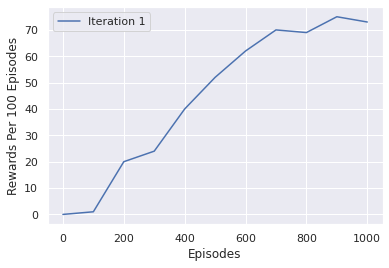

In [ ]:
total_rewards = []
repetition = 10
repetitions += repetition
episodes = 100
datetoday = str(date.today() - timedelta(days = 1))
name = f"Double-DQN-Buffer-Agent-{datetoday}-{repetitions}x{episodes}"
print(name)
if train:
  for rep in range(repetition):
    total_reward = 0
    for ep in range(episodes):
      done = False
      observation = env.reset()
      while not done:
        state = doubledqn_agent.step(env, observation)
        doubledqn_agent.pack(state)
        print(f"Buffer Size: {len(doubledqn_agent.experience_buffer.memory)}")
        print(f"Repetition: {rep}\tTotal Rewards:{total_rewards}\nEpisode: {ep}\tTotal Reward: {total_reward}\t Episilon: {doubledqn_agent.eps}")
        print(f"Observation: {observation}\tAction: {state[2]}")
        observation = state[1]
        done = state[-1]
        total_reward += state[-2]
        env.render()
        clear_output(wait = True)
        doubledqn_agent.train()
    total_rewards.append(total_reward)

  end_training(doubledqn_agent, total_rewards, name, is_double = True)
else:
  load_model(doubledqn_agent, name, is_double = True)
  print("Training set to True")
  train = True

### Actor-Critic Model

In [ ]:
print(environments[1])
env = wrap_env(gym.make(environments[1]))

CartPole-v1


#### Did not manage to get Actor-Critic working


In [ ]:
# class Actor():
#   def __init__(self, observation_size, action_size):
#     self.observation_size = observation_size
#     self.action_size = action_size
#     self.state_input = tf.keras.layers.Input(shape = (1,self.observation_size))
#     self.state_h1 = tf.keras.layers.Dense(24, activation = 'relu')(self.state_input)
#     self.state_h2 = tf.keras.layers.Dense(48, activation = 'relu')(self.state_h1)
#     self.state_h3 = tf.keras.layers.Dense(24, activation = 'relu')(self.state_h2)
#     self.out = tf.keras.layers.Dense(self.action_size, activation = 'relu')(self.state_h3)

#     self.model = tf.keras.models.Model(inputs=self.state_input, outputs = self.out)
#     opt = tf.keras.optimizers.Adam()
#     self.model.compile(
#         optimizer = opt,
#         loss = 'mse',
#         metrics = ['mse', 'mae']
#     )
    

In [ ]:
# class Critic():
#   def __init__(self, observation_size, action_size):
#     self.observation_size = observation_size
#     self.action_size = action_size
#     self.state_input = tf.keras.layers.Input(shape = (1,self.observation_size))
#     self.state_h1 = tf.keras.layers.Dense(24, activation = 'relu')(self.state_input)
#     self.state_h2 = tf.keras.layers.Dense(48, activation = 'relu')(self.state_h1)
    
#     self.action_input = tf.keras.layers.Input(shape = (self.action_size,1))
#     self.action_h1 = tf.keras.layers.Dense(48, activation = 'relu')(self.action_input)

#     self.merged = tf.keras.layers.Add()([self.state_h2, self.action_h1])
#     self.out = tf.keras.layers.Dense(1, activation = 'relu')(self.merged)

#     self.model = tf.keras.models.Model(inputs=[self.state_input, self.action_input], outputs = self.out)

#     self.opt = tf.keras.optimizers.Adam()
#     self.model.compile(
#         optimizer = self.opt,
#         loss = 'mse',
#         metrics = ['mse', 'mae']
#     )

		
    # adam = Adam()
    # model.compile(loss="mse", optimizer=adam)
    # return state_input, action_input, model

In [ ]:
# class ActorCritic():
#   def __init__(self, env, eps = 1.00, discount_rate = 0.99, learning_rate = 0.01, min_buffer = 20, max_buffer = 100, sample_size = 10):
#     self.memory = Memory(max_buffer)

#   def build_table(self):
#     self.actor = Actor(self.observation_size, self.action_size)
#     self.target_actor = Actor(self.observation_size, self.action_size)

#     self.critic = Critic(self.observation_size, self.action_size)
#     self.target_critic = Critic(self.observation_size, self.action_size)

#     actor_weights = self.actor.model.trainable_weights
#     self.actor_critic_gradient = tf.keras.layers.Input([None, self.action_size])
#     self.actor_gradient = tf.gradients(self.actor.out, actor_weights, -self.actor_critic_gradient)
#     gradients = zip(self.actor_gradient, actor_weights)
#     self.actor_optimizer = tf.keras.optimizers.Adam(self.learning_rate).apply_gradients(gradients)
  
#   def update_target_actor(self):
#     self.target_actor.model.set_weights(self.actor.model.get_weights())
#     return
  
#   def update_target_critic(self):
#     self.target_critic.model.set_weights(self.critic.model.get_weights())
#     return

#   def update_target(self):
#     self.update_target_actor()
#     self.update_target_critic()
#     return

#   def step(self, observation):
#     curr_obs =  self.one_hot(observation)
    

In [ ]:
# ac = ActorCritic(env)

In [ ]:
# repetitions = 20